# Harmonic Detection on Torque Data

In [234]:
# Packages libraries
import os # this function is used to interact with the operating system
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import csv
import plotly.express as px
%matplotlib inline
from datetime import datetime
import plotly.express as px

# packages to run autoregression
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pd.options.mode.chained_assignment = None

from pandas.plotting import autocorrelation_plot


# SQL Libraries
import pyodbc

# Json Libraries
import json
from pandas.io.json import json_normalize 

# Use FFT - fast fourier transform
from numpy.fft import fft, ifft

# <span style="color:yellow">**Import Data From SQLServer**</span>

In [262]:
conn = pyodbc.connect('Driver={SQL Server Native Client 11.0};'
                      'Server=FUNSHO-LENOVO;'
                      'Database=A1604ODIN;'
                      'Trusted_Connection=yes;'
                      'UID=user;'
                      'PWD=password;'
                      )
data = pd.read_sql_query('''SELECT *  FROM [A1604ODIN].[Result].[Development_Insights]''', conn)  

c:\Users\funshoa\Anaconda3\envs\python39_sql\lib\site-packages\pandas\io\sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [263]:
data.shape

(281822, 21)

In [264]:
df = data.drop(['ResultID','PartID', 'OperationID', 'Value', 'ValueMin', 'ValueMax', 'Nominal', 'ToleranceMin',
                'ToleranceMax', 'Index', 'Outcome', 'Status'], axis=1)

In [238]:
# This is used if parsing json in python

# Select and work with NOT NULL values only
df = data.dropna(subset=['Torque'])
df.shape

(27762, 21)

In [239]:
px.line(df, x = "TimeStamp", y=["Torque"], labels={
                     "value": "",
                 },
                title="Torque Plot")

In [240]:
print(f"The number of unique 'StationID' are: {df['StationID'].nunique()}\n",
f"These 'StationID' are: {df['StationID'].unique()}\n")

The number of unique 'StationID' are: 5
 These 'StationID' are: [240 310 140 340 180]



In [241]:
# filter out the per station, starting with station 240
stn240 = df.query('StationID == 240')
stn240.shape

(7308, 21)

In [265]:
# Filtering out values that are lower than 0
stn240 = stn240.query('TimeStamp > "30/05/2022 00:00:00.0"')
stn240.shape

(1411, 23)

In [243]:
# add S/N 
stn240.insert(0, 'S/N', range(0, 0 + len(stn240)))

In [244]:
fig = px.line(stn240, x = "S/N", y=["Torque"], title= "Torque Plot For STN240")
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_layout(margin = dict(l=32, r=32, t = 32, b = 32))
fig.show()

In [245]:
# work out fft on data
X = fft(stn240['Torque'])
N = len(X)
n = np.arange(N)

In [246]:
# get the sampling rate
# assume sampling rate, crude estimation of 10 Hz
sr = 1 / 10
T = N/sr
# work out the freq
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# find the abs of onesided FFT
yy = np.abs(X[:n_oneside])

xx = f_oneside

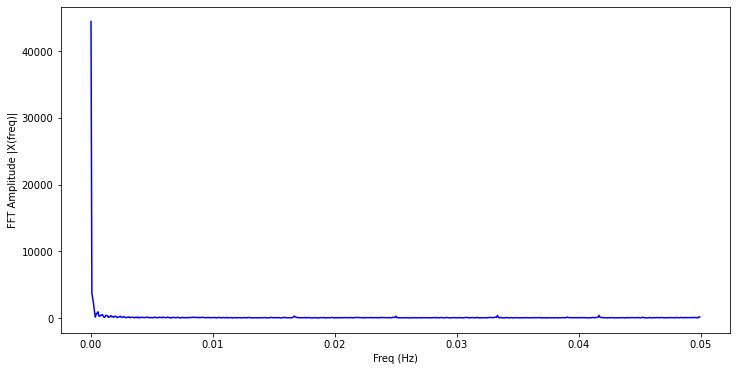

In [247]:
plt.figure(figsize = (12, 6))
plt.plot(xx,yy, 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

In [248]:
# Denoise
D_xx = xx[10:]
D_yy = yy[10:]

In [249]:
dfxx = pd.DataFrame(D_xx, columns= ['Freq (Hz)'])
dfyy = pd.DataFrame(D_yy, columns= ['FFT Amplitude |X(freq)|'])
dfxy = pd.concat([dfxx,dfyy], axis=1)

px.line(dfxy, x="Freq (Hz)", y='FFT Amplitude |X(freq)|',  
                 title="")

In [250]:
# Dfxx = pd.DataFrame(D_xx, columns= ['Freq (Hz)'])
# Dfyy = pd.DataFrame(D_yy, columns= ['FFT Amplitude |X(freq)|'])
# Dfxy = pd.concat([dfxx,dfyy], axis=1)

# px.line(Dfxy, x="Freq (Hz)", y='FFT Amplitude |X(freq)|',  
#                  title="setting up colour palette")

In [251]:
# find peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(D_yy, distance=150)

max_value = max(D_yy)

In [252]:
freq1 = D_xx[peaks[-1]]
freq2 = D_xx[peaks[-2]]
freq3 = D_xx[peaks[-3]]
# print(f"freq1 = {freq1} freq2 = {freq2} freq3 = {freq3}")

# calculate params for datapoints
ts = 1.0/sr
num_points = 7
stop = (1/sr)*num_points
t = np.arange(0,stop,ts)

In [253]:
# determine offset and amplitude
offset = stn240['Torque'].mean()
ampl = stn240['Torque'].std()

# determine new data
y = offset+(ampl*np.sin(2*np.pi*freq1*t)+ampl*np.sin(2*np.pi*freq2*t) +ampl*np.sin(2*np.pi*freq3*t))

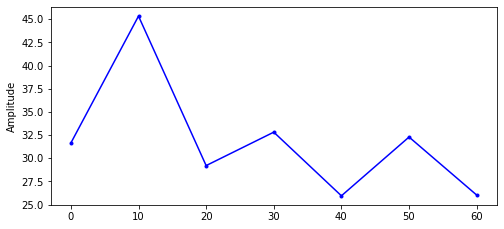

In [254]:
plt.figure(figsize = (8, 8))
plt.subplot(211)
plt.plot(t, y, 'b.-')
plt.ylabel('Amplitude')

plt.show()

In [255]:
# Get last time data point
last_val = stn240['TimeStamp'].iat[-1]

new_t = []

# add new time points
for i in range(len(t)):
	last_val = last_val ;+ 0.1
	new_t.append(last_val)

In [256]:
# create new dictionary to add to existing df
forecast = {'TimeStamp': new_t, 'Torque': y}

df_forecast = pd.DataFrame(forecast)

# append new df to existing df
stn240 = stn240.append(df_forecast, ignore_index=True)

C:\Users\funshoa\AppData\Local\Temp\ipykernel_15520\2866974378.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [257]:
# round the results
stn240['TimeStamp'] = stn240['TimeStamp']
stn240['Torque'] = stn240['Torque']

stn240['Source'] = 'Real'
stn240['Source'][-7:] = 'Predicted'

In [258]:
Stn240_plot_data = stn240.tail(20)

In [259]:
stn240.tail(20)

S/N        SN  ResultID   PartID  StationID  OperationID  \
1391  1391.0  276409.0  322613.0  12893.0      240.0        194.0   
1392  1392.0  280684.0  325011.0  11775.0      240.0        194.0   
1393  1393.0  280686.0  325014.0  11775.0      240.0        194.0   
1394  1394.0  280687.0  325015.0  11775.0      240.0        194.0   
1395  1395.0  280688.0  325016.0  11775.0      240.0        194.0   
1396  1396.0  280690.0  325019.0  11775.0      240.0        194.0   
1397  1397.0  280691.0  325021.0  11775.0      240.0        194.0   
1398  1398.0  280696.0  325025.0  11775.0      240.0        194.0   
1399  1399.0  280697.0  325027.0  11775.0      240.0        194.0   
1400  1400.0  280707.0  325031.0  11775.0      240.0        194.0   
1401  1401.0  280708.0  325032.0  11775.0      240.0        194.0   
1402  1402.0  280714.0  325036.0  11775.0      240.0        194.0   
1403  1403.0  280715.0  325037.0  11775.0      240.0        194.0   
1404     NaN       NaN       NaN      NaN        NaN          NaN   
1405     NaN       NaN       NaN      NaN        NaN          NaN   
1406     NaN       NaN       NaN      NaN        NaN          NaN   
1407     NaN       NaN       NaN      NaN        NaN          NaN   
1408     NaN       NaN       NaN      NaN        NaN          NaN   
1409     NaN       NaN       NaN      NaN        NaN          NaN   
1410     NaN       NaN       NaN      NaN        NaN          NaN   

                      TimeStamp     Torque  TorqueMin  TorqueMax  ...  Value  \
1391 2022-06-30 10:40:26.416360  20.262200       17.0       23.0  ...   None   
1392 2022-06-30 15:01:52.320877  20.258500       17.0       23.0  ...   None   
1393 2022-06-30 15:01:54.110882  20.419700       17.0       23.0  ...   None   
1394 2022-06-30 15:02:01.050931  20.532600       17.0       23.0  ...   None   
1395 2022-06-30 15:02:02.980909  20.052000       17.0       23.0  ...   None   
1396 2022-06-30 15:02:09.784730  20.336800       17.0       23.0  ...   None   
1397 2022-06-30 15:02:11.564977  20.249000       17.0       23.0  ...   None   
1398 2022-06-30 15:02:18.563496  20.415100       17.0       23.0  ...   None   
1399 2022-06-30 15:02:20.320820  20.242500       17.0       23.0  ...   None   
1400 2022-06-30 15:02:27.390986  20.382500       17.0       23.0  ...   None   
1401 2022-06-30 15:02:29.291043  20.465700       17.0       23.0  ...   None   
1402 2022-06-30 15:02:35.760867  20.323800       17.0       23.0  ...   None   
1403 2022-06-30 15:02:37.620905  20.308100       17.0       23.0  ...   None   
1404 2022-06-30 15:02:37.620905  31.649729        NaN        NaN  ...    NaN   
1405 2022-06-30 15:02:37.620905  45.345462        NaN        NaN  ...    NaN   
1406 2022-06-30 15:02:37.620905  29.215026        NaN        NaN  ...    NaN   
1407 2022-06-30 15:02:37.620905  32.822042        NaN        NaN  ...    NaN   
1408 2022-06-30 15:02:37.620905  25.952308        NaN        NaN  ...    NaN   
1409 2022-06-30 15:02:37.620905  32.295886        NaN        NaN  ...    NaN   
1410 2022-06-30 15:02:37.620905  26.035234        NaN        NaN  ...    NaN   

      ValueMin  ValueMax Nominal ToleranceMin ToleranceMax Index Outcome  \
1391      None      None    None         None         None     1       1   
1392      None      None    None         None         None     1       1   
1393      None      None    None         None         None     7       1   
1394      None      None    None         None         None     2       1   
1395      None      None    None         None         None     8       1   
1396      None      None    None         None         None     3       1   
1397      None      None    None         None         None     9       1   
1398      None      None    None         None         None     4       1   
1399      None      None    None         None         None     1       1   
1400      None      None    None         None         None     5       1   
1401      None      None    None         N

In [260]:
px.line(Stn240_plot_data,  y='Torque',  color='Source',markers=True, 
                 title="Torque Predictions vs. Real")

In [261]:
# store in CSV
df.to_csv('stationID240.csv')